# Test tiger with location scale regression

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

rng = np.random.default_rng(42)

## Simulate data

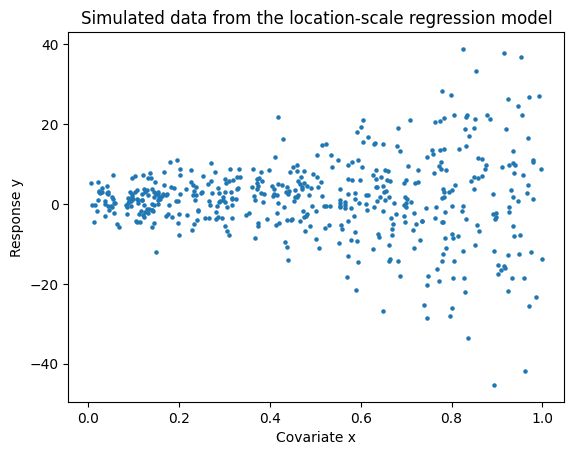

In [2]:
# sample size and true parameters

n = 500
true_beta = np.array([1.0, 2.0])
true_gamma = np.array([1.0, 2.0])

# data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
Z_mat = np.column_stack([np.ones(n), x0])
log_sigma = Z_mat @ true_gamma
sigma = np.exp(log_sigma)
eps = rng.normal(scale=sigma, size=n)
response_vec = X_mat @ true_beta + eps

# plot the simulated data

plt.scatter(x0, response_vec, s = 5)
plt.title("Simulated data from the location-scale regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [3]:
# set up design matrix location
X = tiger.Obs(name = "X")
X.fixed(data = x0)

# set up design matrix scale
Z = tiger.Obs(name = "Z")
Z.fixed(data = x0)

# set up hyperparameters
beta_loc = tiger.Hyper(0, name="beta_loc")
beta_scale = tiger.Hyper(100, name="beta_scale")

# set up parameters for the location
beta_dist = tiger.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# set up hyperparameters
gamma_loc = tiger.Hyper(0, name="gamma_loc")
gamma_scale = tiger.Hyper(100, name="gamma_scale")

# set up parameters for the scale
gamma_dist = tiger.Dist(tfd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.array([0.0, 0.0]), distribution=gamma_dist, name="gamma")

# set up the linear predictors
lpred_loc = tiger.Lpred(Obs=X, beta=beta)
lpred_scale = tiger.Lpred(Obs=Z, gamma=gamma, function=jnp.exp)

# set up response distribution
response_dist = tiger.Dist(tfd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [4]:
jnp.sum(m.log_lik)

Array(-26417.957, dtype=float32)

In [5]:
m.log_prior

Array(-22.096436, dtype=float32)

In [6]:
m.log_prob

Array(-26440.053, dtype=float32)

In [7]:
graph = tiger.ModelGraph(Model=m)
graph.build_graph()

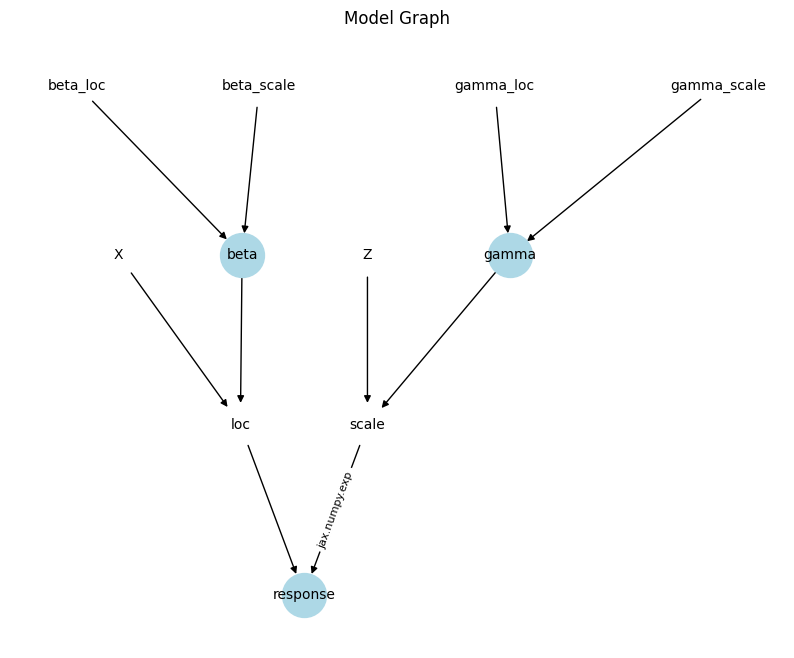

In [8]:
graph.visualize_graph()

## Inference with BBVI

In [18]:
q = bbvi.Bbvi(Graph=graph, num_samples=64, num_iterations=20000, key=27)

In [19]:
q.run_bbvi(step_size=0.001, threshold=1e-5, chunk_size=1000)

(Array(-1739.1917, dtype=float32),
 {'beta': {'mu': Array([1.0113721, 1.0258723], dtype=float32),
   'cov': Array([[ 0.16611688, -0.47933638],
          [-0.47933638,  2.2631152 ]], dtype=float32)},
  'gamma': {'mu': Array([1.0017816, 2.039219 ], dtype=float32),
   'cov': Array([[ 0.0047442, -0.0079962],
          [-0.0079962,  0.0176099]], dtype=float32)}})

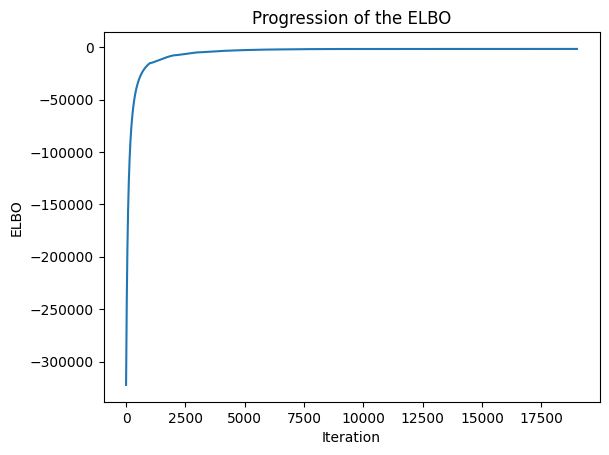

In [20]:
q.plot_elbo()